In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Load the data from folders
DIR = "/content/drive/My Drive/WasteClassification/WasteImagesDataset"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

# Get all the classes
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

# Tune and optimize the buffer size for optimal performance.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7608 files belonging to 9 classes.
Using 6848 files for training.
Found 7608 files belonging to 9 classes.
Using 760 files for validation.
['Electronics', 'Glass', 'Medical', 'Metal', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


In [ ]:
from pathlib import Path
import imghdr
import os

data_dir = DIR
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [11]:
# Create the base model from the pre-trained convnets
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)

#Freeze the convolutional base
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)
model = tf.keras.Model(inputs=baseModel.input,outputs=x)

# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Modify the learning rate during training
epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

Epoch 1/50
54/54 [==============================] - 621s 11s/step - loss: 344.4341 - accuracy: 0.5905 - val_loss: 269.6927 - val_accuracy: 0.2447
Epoch 2/50
54/54 [==============================] - 69s 1s/step - loss: 176.7109 - accuracy: 0.7074 - val_loss: 170.6944 - val_accuracy: 0.7447
Epoch 3/50
54/54 [==============================] - 67s 1s/step - loss: 161.5815 - accuracy: 0.7880 - val_loss: 163.9362 - val_accuracy: 0.7895
Epoch 4/50
54/54 [==============================] - 66s 1s/step - loss: 161.8507 - accuracy: 0.7861 - val_loss: 167.5314 - val_accuracy: 0.7684
Epoch 5/50
54/54 [==============================] - 71s 1s/step - loss: 165.4753 - accuracy: 0.7723 - val_loss: 173.2665 - val_accuracy: 0.5908
Epoch 6/50
54/54 [==============================] - 67s 1s/step - loss: 164.4631 - accuracy: 0.8065 - val_loss: 165.4356 - val_accuracy: 0.7921
Epoch 7/50
54/54 [==============================] - 66s 1s/step - loss: 164.2648 - accuracy: 0.7970 - val_loss: 165.1123 - val_accurac

In [12]:
model.save("/content/trained_pipeline-0.1.0.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [13]:
# Load the saved model for testing
trained_model = tf.keras.models.load_model('trained_pipeline-0.1.0.h5')

1/1 [==============================] - 2s 2s/step
['Electronics', 'Glass', 'Medical', 'Metal', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction scores for all the classes:
[5.0481521e-02 3.2967865e+00 3.5128803e+00 2.4062620e-02 5.1183545e-14
 9.3044876e+01 3.1272314e-02 3.9642144e-02 2.9253658e-13]
Prediction: Paper and Cardboard with a 93.04% confidence


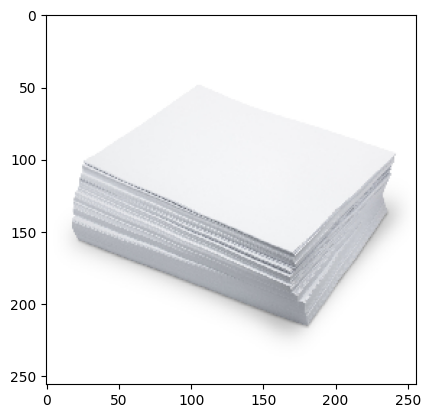

In [14]:
# Get the path of test image
path = "/content/paper.jpg"

# Load and preprocessing the image
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make a prediction
predictions = trained_model.predict(img_array)
rounded_max_prob = round(predictions[0][np.argmax(predictions)]*100, 2)

# Plot test image
plt.imshow(img)

# Print the results
print(f"{classes}")
print(f"Prediction scores for all the classes:\n{predictions[0]*100}")
print(f"Prediction: {classes[np.argmax(predictions)]} with a {rounded_max_prob}% confidence")

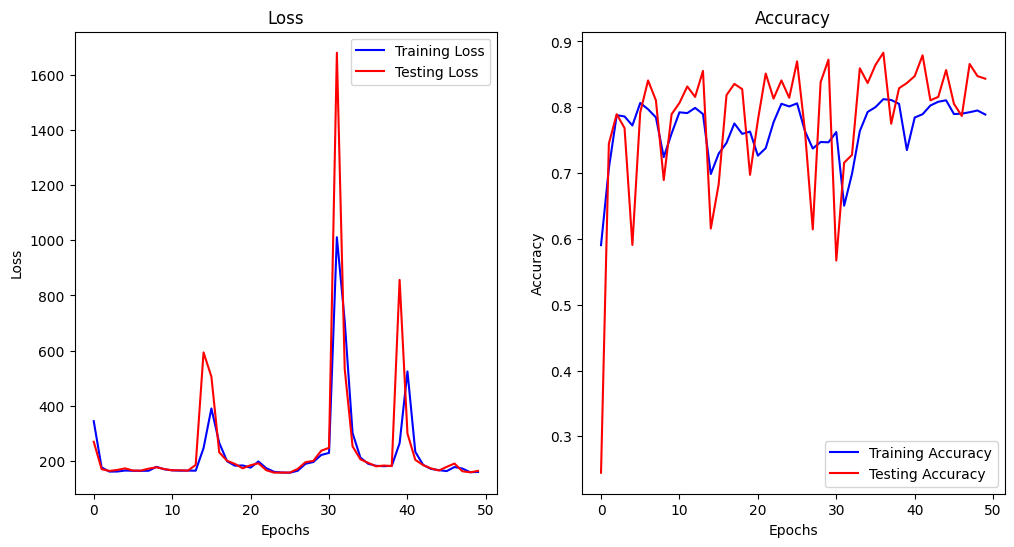

In [15]:
# Create subplot to plot training and testing history
fig,axes = plt.subplots(1,2, figsize=(12, 6))

# Loss
axes[0].plot(range(0, epochs), history.history["loss"], color="b", label="Training Loss")
axes[0].plot(range(0, epochs), history.history["val_loss"], color="r", label="Testing Loss")
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Loss')
axes[0].set_title('Loss')


# Accuracy
axes[1].plot(range(0, epochs), history.history["accuracy"], color="b", label="Training Accuracy")
axes[1].plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Testing Accuracy")
axes[1].legend()
axes[1].set(xlabel='Epochs', ylabel='Accuracy')
axes[1].set_title('Accuracy')

# Save model image
plt.savefig('Model_History')
plt.show()

Text(0, 0.5, 'Loss')

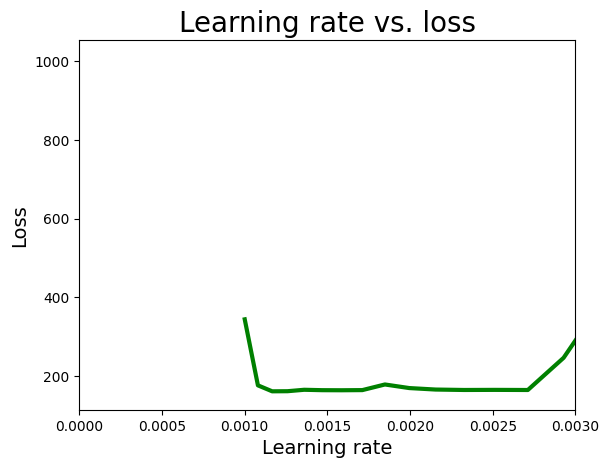

In [21]:
# Plot the learning rate
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='g')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)


In [17]:
from pathlib import Path
from PIL import Image
from io import BytesIO

In [18]:
IMAGE_SHAPE = (256, 256)
classes = ['Electronics', 'Glass', 'Medical', 'Metal', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
model = tf.keras.models.load_model('trained_pipeline-0.1.0.h5')
print("Load the model ...")

Load the model ...


In [19]:
# Predict
def tf_predict(image: Image.Image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.resize(IMAGE_SHAPE))
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    rounded_max_prob = round(predictions[0][np.argmax(predictions)]*100, 2)

    print(f"Prediction: {classes[np.argmax(predictions)]} with a {rounded_max_prob}% confidence")

    return classes[np.argmax(predictions)],rounded_max_prob

1/1 [==============================] - 1s 958ms/step
Prediction: Medical with a 100.0% confidence


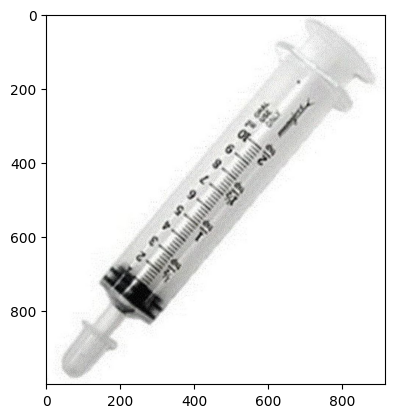

In [20]:
# Get the image path
image_path = "syringe.jpg"
image = tf.keras.preprocessing.image.load_img(image_path)
plt.imshow(image)
class_predicted = tf_predict(image)
